# Imports

In [1]:

import pandas as pd
import numpy as np
import math
from itertools import product
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt

import os

In [2]:
df = pd.read_csv('data/XBTUSDC_1.csv', header=None,
                 names=['time', 'open', 'high', 'low', 'close', 'volume', 'trades'])
df.set_index('time', inplace=True)
df.index = pd.DatetimeIndex(df.index * 1e+9)

In [3]:
len(df)

80826

In [4]:
class Trader1:
    # Bollinger: https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends/#:~:text=Using%20the%20bands%20as%20overbought,have%20deviated%20from%20the%20mean.
    def __init__(self, n_cycles, n_devs, qty, take_at=0.005, fee=0.0026):
        # qty = quantity to trade at a time
        # EMA = Closing price x multiplier + EMA (previous day) x (1-multiplier)
        # 
        # BOLU=MA(TP,n)+m∗σ[TP,n]
        # BOLD=MA(TP,n)−m∗σ[TP,n]
        # where:
        # BOLU=Upper Bollinger Band
        # BOLD=Lower Bollinger Band
        # MA=Moving average
        # TP (typical price)=(High+Low+Close)÷3
        # n=Number of cycles in smoothing period ... n_cycles
        # m=Number of standard deviations ... n_devs
        # σ[TP,n]=Standard Deviation over last n periods of TP
        #
        # take_at = take profit at p0 * (1 + someting% + 2*fee)
        self.N = n_cycles
        self.M = n_devs
        self.qty = qty
        self.take_at = take_at
        self.fee = fee
        self.prices = np.array([0.] * self.N)
        
        self.sma = None
        self.upper = None
        self.lower = None
        self.var = None
        self.std = None
        self.open_price = None
        self.profit_price = None
        self.loss_price = None
    
        self.position = 0
        self.trades = []
        
        self.warming_up = True
        self.i = 0
    
    def update(self, cycle, ohlc: dict, price):
        _, high, low, close = self._unpack(ohlc)

        last_price = self.prices[self.i]
        self.prices[self.i] = price
        self.i += 1
        if self.i == len(self.prices):
            self.i = 0
            if self.warming_up:
                self.warming_up = False
                self.sma = np.mean(self.prices)
                self.var = np.var(self.prices)
                self.std = math.sqrt(self.var)
                self.upper = self.sma + self.M * self.std
                self.lower = self.sma - self.M * self.std
                return

        if not self.warming_up:
            old_sma = self.sma
            self.sma += (price - last_price) / self.N
            self.var += (price - self.sma + last_price - old_sma)*(price - last_price)/(self.N)
            self.var = self.check_var(self.var)
            self.std = math.sqrt(self.var)
            self.upper = self.sma + self.M * self.std
            self.lower = self.sma - self.M * self.std
            
    def check(self, x):
        if np.abs(x) > 0.01:
            raise
    
    def check_var(self, var):
        if var < 0:
            if abs(var) >= 1.e-4:
                raise Exception(f'var was {var}')
            return 0.
        return var
    
    def trade(self) -> float:  # return number of shares to trade
        if self.warming_up:
            return None
        price = self.prices[self.i]
        # buy
        if price < self.lower and self.position <= 0:
            if self.position == 0:
                self.open_price = price
                self.profit_price = price + self.take_at + 2*self.fee
                self.loss_price = price - (self.take_at + 2*self.fee)
            self.position += self.qty
            return self.qty
    
        # sell
        if price > self.upper and self.position >= 0:
            if self.position == 0:
                self.open_price = price
                self.loss_price = price + self.take_at + 2*self.fee
                self.profit_price = price - (self.take_at + 2*self.fee)
            self.position -= self.qty
            return -self.qty
        
        # profit
        if self.position > 0:
            if not self.loss_price <= price <= self.profit_price:
                self.position -= self.qty
                return -self.qty
        elif self.position < 0:
            if not self.profit_price <= price <= self.loss_price:
                self.position += self.qty
                return +self.qty
    
    @staticmethod
    def _unpack(ohlc: dict):
        return ohlc['open'], ohlc['high'], ohlc['low'], ohlc['close']

# DcatTrader

In [172]:
# Model that assumes we have aggregated information from the future
class DcatTrader:
    def __init__(self, window, actual_prices, take_min, qty, fee):
        self.y = self.get_y2(window, actual_prices)
        self.i = -1
        self.position = 0
        self.entry_price = 0
        self.price = 0
        self.take_min = take_min
        self.qty = qty
        self.fee = fee
        
    def update(self, _, __, price):
        self.i += 1
        self.price = price
        
        pass
    
    def trade(self):
        if np.isnan(self.y[self.i]):
            return
        
        # effective pnl% in terms of return r:
        #    pnl/(p0*|q|) = r*sign(q) - fee*(2+r)
        #                 = r*(sign(q) - f) - 2*fee
        
        t = self.take_min
        f = self.fee
        if self.position == 0:
            r = self.y[self.i]
            
            is_good_buy = r >= (t+2*f)/(1-f)
            is_good_sell = r <= -(t+2*f)/(1+f)
        else:
            r = (self.price - self.entry_price)/self.entry_price
            
            is_good_buy = self.position < 0 and r <= -(t+2*f)/(1+f)
            is_good_sell = self.position > 0 and r >= (t+2*f)/(1-f)
            
        if is_good_buy:
            self.entry_price = self.price if self.position == 0 else np.nan
            self.position += self.qty  
            return self.qty
        elif is_good_sell:
            self.entry_price = self.price if self.position == 0 else np.nan
            self.position -= self.qty 
            return -self.qty          
            
        return 0
    
    def get_y2(self, w, prices):
                
        ma = prices.iloc[::-1].rolling(w).max()
        mi = prices.iloc[::-1].rolling(w).min()
        s = (ma + mi).iloc[::-1]
        return (.5*(s - 2.*prices)/prices)

In [180]:
def trade(df, model):
    # model needs to have .update(cycle, ohlc) and trade()
    # return the trades

    trades = pd.DataFrame(index=df.index)
    trades['qty'] = [0.] * len(trades)
    
    for i, (cycle, ohlc) in enumerate(df.iterrows()):
        model.update(cycle, ohlc, ohlc['close'])
        qty = model.trade()
        if qty:
            trades.iloc[i] = qty
    return trades

def account(prices, trades, fee=0.0026):
    #prices = df.open
    volume = prices * trades.qty * (1 + np.sign(trades.qty) * fee)

    last_price = prices.iloc[-1]
    qty_to_liquidate = -trades.qty.sum()
    last_volume = last_price * qty_to_liquidate * (1 + np.sign(qty_to_liquidate) * fee)

    pnl = -(last_volume + volume.sum())
    
    return pnl

def cycle_realized_pnl(prices, trades, fee=0.0026):
    #prices = df.open.shift(-1, fill_value=df.open.iloc[-1])
    volume = prices * trades.qty * (1 + np.sign(trades.qty) * fee)
    
    values = pd.DataFrame(index=prices.index, columns=['pnl', 'adjusted_pnl']).fillna(0.)
    v = 0.
    position = 0.
    max_position = 0.
    open_price = 0.
    for i, qty in enumerate(trades.qty):
        was_open = position != 0
        
        position = round(position + qty, 8)
        max_position = max(abs(position), max_position)
        v -= volume.iloc[i]
        
        if not was_open and position != 0:
            open_price = prices[i]
        
        if position == 0:
            if was_open:
                market_pnl = max_position * abs(prices[i] - open_price)
                #market_pnl -= fee * max_position * (prices[i] + open_price)
                values.iloc[i] = (v, v - market_pnl)
            v = 0
            max_position = 0
            
    if position:
        last_price = prices.iloc[-1]
        assert np.isclose(position, trades.qty.sum()), f'position={position}, trades.qty.sum()={trades.qty.sum()}'
        qty_to_liquidate = -position
        last_volume = last_price * qty_to_liquidate * (1 + np.sign(qty_to_liquidate) * fee)
        assert values.iloc[-1][0] == 0
        
        market_pnl = max_position * abs(prices[i] - open_price)
        #market_pnl -= fee * max_position * (prices[i] + open_price)
        values.iloc[i] = (-last_volume + v, -last_volume + v - market_pnl)
        
        #values.iloc[-1] = -last_volume + v
    return values

def robustness(pnls, prices):
    # It should tell how much the model depends on the market
    returns = (prices.shift(-1) - prices)/prices
    idx = pnls != 0
    a = pnls[idx][:-1].corr(prices[idx][:-1])
    return 1 - a*a


def sharpe(pnls):
    return np.sum(pnls) / np.std(pnls)

def test_account():
    #df = pd.DataFrame({'open': [10,11,12,13,14]})
    #prices = df['open'].shift(-1, fill_value=df.open.iloc[-1])
    prices = pd.Series([11,12,13,14,14])
    
    trades = pd.DataFrame({'qty': [1,-1,1,0,0]})
    fee = 1
    a = cycle_realized_pnl(prices, trades, fee=fee).pnl.sum()
    b = account(prices, trades, fee=fee)
    assert a == b
    assert a == -48.
    c = cycle_realized_pnl(prices, trades, fee=fee).adjusted_pnl.sum()
    assert c == -50., f'c = {c}'

test_account()

# Run Sim

In [188]:
trades = trade(df, Trader1(10, 2, 0.002))
acc = cycle_realized_pnl(df, trades)
sharpe(acc.pnl), sharpe(acc.adjusted_pnl)

(-17652.73139847319, -17980.460262671964)

In [182]:
trades = trade(df, DcatTrader(75, actual_prices=df.close,
                              take_min=0.005, qty=0.002, fee=0.0026))
acc = cycle_realized_pnl(df.close, trades)
rob = robustness(acc.pnl, df.close)
sharpe(acc.pnl), len(acc.pnl[acc.pnl < 0]), len(acc.pnl[acc.pnl > 0]), rob
# (6058.5075476589045, -8191.272070021878), (33, 1103)

(10046.515901276536, 0, 1925, 0.5805772782733891)

(0, 1925)

In [126]:
acc.pnl[acc.pnl < 0].head(1)

time
2020-01-21 18:58:00   -0.002824
Name: pnl, dtype: float64

In [158]:
r = -0.005
fee = 0.003
qty = -0.0002

# pnl/(p0*|q|) = r*sign(q) - fee*(2+r)
r*np.sign(qty) - fee*(2+r)

-0.0009850000000000006

In [164]:
for i in [30]:
    fee = 0.0001 * i
    print(fee, (0.005 + 2*fee)/(1-fee), -(0.005 + 2*fee)/(1+fee))

0.003 0.011033099297893681 -0.010967098703888336


In [166]:
0.010967098703888336 - fee * (2 -0.010967098703888336)

0.005000000000000001

In [147]:
(8652.87 * (1-0) - 8609.40 * (1+0))*0.002

0.08694000000000233

In [223]:
trades.loc['2020-02-17 16:50:00']

qty   -0.002
Name: 2020-02-17 16:50:00, dtype: float64

In [225]:
prices.open['2020-02-17 16:50:00']

9728.42

In [127]:
a = pd.merge(trades, df, left_index=True, right_index=True)
a = pd.merge(a, acc, left_index=True, right_index=True)
a = a[a.qty!=0]

In [136]:
b = a.query('time <= "2020-01-21 18:58:00" and time >= "2020-01-21 03:21:00"')
b

,qty,open,high,low,close,volume,trades,pnl,adjusted_pnl
time,,,,,,,,,
2020-01-21 03:21:00,-0.002,8652.87,8652.87,8652.87,8652.87,0.014690,1,0.000000,0.000000
2020-01-21 18:58:00,0.002,8609.40,8609.40,8609.40,8609.40,0.007497,1,-0.002824,-0.089764


In [139]:
cycle_realized_pnl(b.close, b, fee=0)

,pnl,adjusted_pnl
time,,
2020-01-21 03:21:00,0.00000,0.000000e+00
2020-01-21 18:58:00,0.08694,3.233525e-15


# Plotting

In [47]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as offline

def plot(df, trades):
    # df columns = ['open', 'high', 'low', 'close', 'volume', 'trades']
    # trades columns = ['qty']

    buys = df.open[trades.qty > 0]
    sells = df.open[trades.qty < 0]
    pnls = cycle_realized_pnl(df, trades).pnl
    pnls = pnls[pnls != 0]
    pnls = pnls.cumsum()
    
    trace = go.Scatter(
        x=df.index,
        y=df['open'],
        name='Tick'
    )

    trace2 = go.Scatter(
        x=buys.index,
        y=buys,
        #text=buys['order_id'],
        #hoverinfo='text',
        name='Buy',
        mode='markers',
        marker=dict(
            size=10,
            color='rgba(182, 255, 193, .9)',
            line=dict(
                width=2,
            )
        )
    )

    trace3 = go.Scatter(
        x=sells.index,
        y=sells,
        #text=sells['order_id'],
        #hoverinfo='text',
        name='Sell',
        mode='markers',
        marker=dict(
            size=7,
            color='rgba(255, 182, 193, .9)',
            line=dict(
                width=1,
            )
        )
    )

    trace4 = go.Scatter(
        x=pnls.index,
        y=pnls,
        name='P&L',
        mode='lines+markers',
        marker=dict(
            size=5,
            color='rgba(193, 182, 255, .9)',
            line=dict(
                width=1,
            )
        ),
        yaxis='y2'
    )
    
    data = [trace, trace2, trace3, trace4]
    layout = go.Layout(
        title='Trading log',
        yaxis=dict(
            title='Price'
        ),
        yaxis2=dict(
            title='BTC',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        ),
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        ),
        xaxis2=dict()
    )

    fig = go.Figure(data=data, layout=layout)
    offline.plot(fig, auto_open=True, filename=os.path.join('/Users/felipe/crypto/bitme2', 'results_plot.html'))
    # offline.iplot(fig)  #

    return 0

In [48]:
plot(df, trades)

0

# Model research

In [2]:
prices = pd.read_csv('data/XBTUSDC_1.csv', header=None,
                     names=['time', 'open', 'high', 'low', 'close', 'volume', 'trades'])
prices = prices.set_index('time')
prices.index = pd.DatetimeIndex(prices.index * 1e+9)
prices = prices.reindex(index=pd.date_range(prices.index[0], prices.index[-1],
                        freq=pd.Timedelta('00:01:00')), method='ffill', copy=False)

In [ ]:
returns = (prices.close - prices.open) / prices.open

In [176]:
def get_y(w, prices):
    ma = prices.iloc[::-1].rolling(w).max()
    mi = prices.iloc[::-1].rolling(w).min()
    s = (ma + mi).iloc[::-1]
    return (.5*(s - 2.*prices)/prices)

In [168]:
get_y(75)

2020-01-08 15:29:00   -0.004969
2020-01-08 15:30:00   -0.004969
2020-01-08 15:31:00   -0.004969
2020-01-08 15:32:00   -0.004969
2020-01-08 15:33:00   -0.004969
                         ...   
2021-03-31 23:48:00         NaN
2021-03-31 23:49:00         NaN
2021-03-31 23:50:00         NaN
2021-03-31 23:51:00         NaN
2021-03-31 23:52:00         NaN
Freq: T, Length: 645624, dtype: float64

In [164]:
pd.Series((get_y(75).clip(lower=0))).corr(pd.Series((returns.iloc[::-1].rolling(75).max().iloc[::-1])))

0.3818672783342885

## volatility per interval

In [ ]:
interval_std = {}
for interval in (2, 5, 30, 60, 120, 300, 24*60, 7*24*60):
    interval_std[interval] = (returns - returns.rolling(interval, center=True).mean()).abs().std()

In [ ]:
returns.abs().mean()

In [ ]:
interval_std

In [ ]:
30/61000

In [ ]:
returns.iloc[-100:].plot()

In [ ]:
returns.std()

* Conclusion: they are all about the same

## Optimal interval

It should be the interval that the lagged Y predicts Y

## cost and get_x_y

In [140]:
# Sum forward is not a good metric because sum(returns) == 0 
# doesn't mean that price[n] - price[0] == 0. 
def sum_forward(s, w):
    return s.iloc[::-1].rolling(w).sum().iloc[::-1].shift(-1)

def peak_forward(s, w)
    ma = s.iloc[::-1].rolling(w).max()
    mi = s.iloc[::-1].rolling(w).min()
    return ((ma + mi)).iloc[::-1].shift(-1)

def apply_threshold(s, threshold):
    s[s.abs() < threshold] = np.nan

def cost(returns, threshold=0.01):
   
    def _helper(args):
        lookback, lookahead = (int(i) for i in args)
        if lookback <= 0 or lookahead <= 0:
            return float('inf')
        left = returns.rolling(lookback).sum()
        right = sum_forward(returns, lookahead)
        apply_threshold(left, threshold)
        apply_threshold(right, threshold)
        return -left.corr(-right)
    return _helper

# features
def get_x_y(returns, lookback, lookahead):
    return pd.DataFrame({
        'sum': returns.rolling(lookback).sum(),
        'high': returns.rolling(lookback).max(),
        'low': returns.rolling(lookback).min(),
        'open': returns.shift(lookback),
        'close': returns,
        'y': sum_forward(returns, lookahead)
    }, index=returns.index)

def get_acceleration(returns, lookback, lookahead):
    return pd.DataFrame({
        'sum': (returns - returns.shift()).ewm(span=lookback).mean()*lookback,
        #'sum': (returns ).ewm(span=lookback).mean()*lookback,
        #'sum': (returns - returns.shift()).rolling(lookback).sum(),
        'y': sum_forward(returns, lookahead)
    }, index=returns.index)

def get_acc_cost(returns, threshold=0.01):
    a = get_acceleration(returns, lookback, 75)
    apply_threshold(a['sum'], threshold)
    apply_threshold(a['y'], threshold)
    return -a['sum'].corr(a['y'])

In [141]:
results = {}
for lookback in range(5500,9000, 100):
    a = get_acceleration(returns, lookback, 10)
    results[lookback] = get_acc_cost(returns)

In [142]:
sorted(results.items(), key=lambda x: results[x[0]])[:5]

[(8700, -0.443703817488204),
 (8600, -0.443701616629152),
 (8500, -0.44369975947459855),
 (8800, -0.4436764259041431),
 (8900, -0.44366227519348084)]

In [143]:
1.44/2

0.72

### Best ewm span: 6200 with 72%

In [ ]:
pd.Series([1,2]).shift()

In [ ]:
pd.DataFrame({'a': pd.Series([1,2,3]), 'b': pd.Series([1,2,3])})

In [ ]:
cost(returns)([76, 76])

In [ ]:
from scipy.optimize import minimize

In [ ]:
x0 = [150, 150]

In [ ]:
res = minimize(cost(returns), x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

res

In [ ]:
results = {}

In [ ]:
%%time
args = []
for lookback in range(50,101):
    for lookahead in range(50,101):
        args.append((lookback, lookahead))
for i in trange(len(args)):
    results[args[i]] = cost(returns)( args[i] )

In [ ]:
sorted(results.items(), key=lambda x: results[x[0]])

### Conclusion: 75 mins lookback sum predicts 75 forward with 58% confident

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection

## Model selection

In [8]:
X = get_x_y(returns, 75, 75).dropna().astype(float)
X = X[['sum', 'high', 'low', 'open', 'close', 'y']].astype(float)
#index = (~X.isna()) & (~Y.isna())
#X = X[index]
#Y = Y[index]
#assert (X.index == Y.index).all()

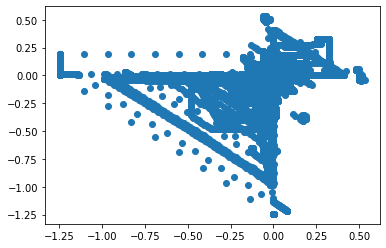

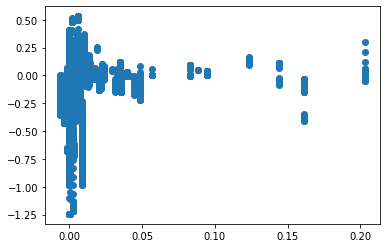

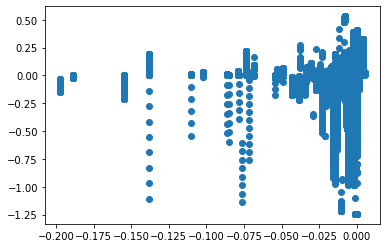

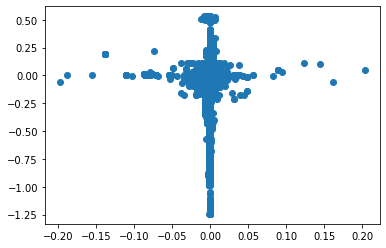

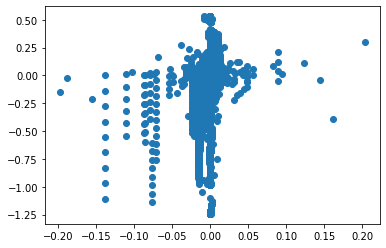

In [9]:
for index, feature_name in enumerate(['sum', 'high', 'low', 'open', 'close']):
#for index, feature_name in enumerate(['sum']):

    plt.figure()
    plt.scatter(X.iloc[:, index], X.y) 

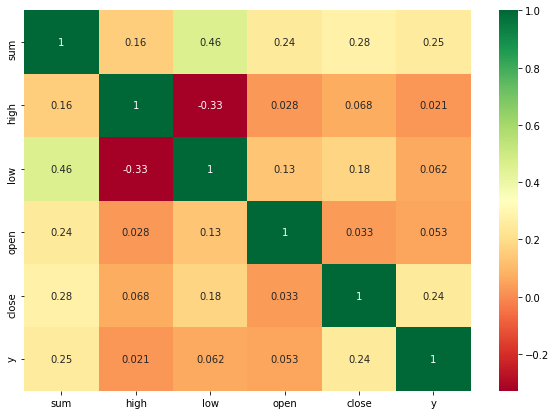

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
#data = pd.read_csv("D://Blogs//train.csv")
#X = data.iloc[:,0:20]  #independent columns
#y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,7))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.values, y.values,
                            test_size=0.25)

for Model in [GaussianNB, KNeighborsClassifier, LinearSVC]:
    clf = Model().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('%s: %s' %
          (Model.__name__, metrics.f1_score(y_test, y_pred, average="macro")))  


In [13]:
x = np.arange(100) / 100 * np.pi * 2

In [51]:
f1 = x/200 + np.sin(x)**2
f2 = x/200 + np.cos(x)**2
y = x/100+1

In [58]:
pd.Series(f1).corr(pd.Series(f2))

-0.9986858369520066

In [53]:
pd.Series(y).corr(pd.Series(f1))

0.05009790187704255

In [54]:
pd.Series(y).corr(pd.Series(f2))

0.0011539372564815366

In [55]:
pd.Series(y).corr(pd.Series(f1 + f2))

1.0

In [35]:
pd.Series(y).corr(pd.Series(np.ones(len(x)) - y/10000))

-0.9999999999999991

In [33]:
y

array([1.07386837, 0.9446583 , 1.04469854, 1.05263511, 1.0723699 ,
       1.05086024, 0.90678081, 0.96766913, 1.07045225, 1.00190759,
       1.00557083, 1.06800973, 0.91704055, 1.08559459, 0.97673616,
       1.08666827, 1.03970641, 1.04285202, 1.02039027, 0.95014885,
       1.03244568, 1.00642595, 0.95091415, 1.03559054, 1.02528672,
       1.02564414, 0.91510041, 1.06390073, 0.90469254, 0.96769897,
       0.95409013, 0.92300066, 1.03773116, 1.03674758, 0.94865346,
       1.06530486, 0.95135872, 1.0764614 , 0.94128682, 0.98035795,
       1.06520113, 1.04517076, 0.98717198, 0.96074882, 1.02323894,
       1.06838479, 0.99196901, 1.01701029, 0.93052532, 1.08390187,
       1.06763247, 1.09612392, 1.06351281, 1.00806035, 1.0336972 ,
       0.96335654, 0.91406797, 1.02982024, 0.98475751, 0.91843641,
       0.94281054, 1.03803861, 1.09974859, 0.95517947, 1.08433376,
       0.97928508, 1.03099411, 0.9309868 , 1.08731878, 1.0507036 ,
       1.0804188 , 1.07447059, 0.9244601 , 0.9933916 , 1.04131